In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

!pip install pyLDAvis
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [ ]:
pathcov = '/content/drive/My Drive/covid311.csv'
covid = pd.read_csv(pathcov)

pathnocov = '/content/drive/My Drive/nocovid311.csv'
nocovid = pd.read_csv(pathnocov)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (20,31) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (8,18,31) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
covid

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,45727718,03/01/2020 12:00:00 AM,03/02/2020 10:37:56 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10468.0,2297 CEDAR AVENUE,CEDAR AVENUE,WEST FORDHAM ROAD,LANDING ROAD,WEST FORDHAM ROAD,LANDING ROAD,ADDRESS,BRONX,CEDAR AVENUE,NaN,Closed,NaN,NaN,03/02/2020 10:37:56 AM,07 BRONX,2.032350e+09,BRONX,1008824.0,253422.0,ONLINE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.862225,-73.911159,"(40.86222535202683, -73.91115884964748)"
1,45728413,03/01/2020 12:00:00 AM,03/02/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10128.0,1570 3 AVENUE,3 AVENUE,EAST 88 STREET,EAST 89 STREET,EAST 88 STREET,EAST 89 STREET,ADDRESS,NEW YORK,3 AVENUE,NaN,Closed,NaN,The Department of Health and Mental Hygiene ha...,03/09/2020 01:43:52 PM,08 MANHATTAN,1.015170e+09,MANHATTAN,997285.0,223557.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.780279,-73.952933,"(40.78027896232064, -73.95293321926803)"
2,45730477,03/01/2020 12:00:00 AM,03/02/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10468.0,2297 CEDAR AVENUE,CEDAR AVENUE,WEST FORDHAM ROAD,LANDING ROAD,WEST FORDHAM ROAD,LANDING ROAD,ADDRESS,BRONX,CEDAR AVENUE,NaN,Closed,NaN,The Department of Health and Mental Hygiene ha...,03/09/2020 01:45:36 PM,07 BRONX,2.032350e+09,BRONX,1008824.0,253422.0,ONLINE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.862225,-73.911159,"(40.86222535202683, -73.91115884964748)"
3,45731136,03/01/2020 12:00:00 AM,03/09/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11691.0,20-17 MOTT AVENUE,MOTT AVENUE,BEACH 20 STREET,BEACH 21 STREET,BEACH 20 STREET,BEACH 21 STREET,ADDRESS,Far Rockaway,MOTT AVENUE,NaN,Closed,NaN,The Department of Health and Mental Hygiene re...,03/09/2020 01:44:57 PM,14 QUEENS,4.157040e+09,QUEENS,1052826.0,159548.0,PHONE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.604333,-73.753038,"(40.60433339241671, -73.75303800188094)"
4,45731855,03/01/2020 12:00:00 AM,03/02/2020 10:19:39 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10458.0,2954 WEBSTER AVENUE,WEBSTER AVENUE,BEDFORD PARK BOULEVARD,BOTANICAL SQUARE SOUTH,BEDFORD PARK BOULEVARD,BOTANICAL SQUARE SOUTH,ADDRESS,BRONX,WEBSTER AVENUE,NaN,Closed,NaN,The Department of Health and Mental Hygiene ha...,03/02/2020 10:19:39 AM,07 BRONX,2.032740e+09,BRONX,1016502.0,255313.0,ONLINE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.867391,-73.883392,"(40.867390857417874, -73.8833918894606)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649622,49894212,02/28/2021 11:58:01 PM,03/01/2021 12:35:28 AM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10467.0,66 WEST GUN HILL ROAD,WEST GUN HILL ROAD,GATES PLACE,WEST MOSHOLU PARKWAY NORTH,GATES PLACE,WEST MOSHOLU PARKWAY NORTH,NaN,BRONX,WEST GUN HILL ROAD,NaN,Closed,NaN,The Police Department responded to the complai...,03/01/2021 05:35:30 AM,07 BRONX,2.033240e+09,BRONX,1016379.0,261052.0,MOBILE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.883143,-73.883809,"(40.88314307829552, -73.88380907664076)"
26

In [ ]:
covid['Created Date']=pd.to_datetime(covid['Created Date'], infer_datetime_format=True)
covid['Date']=covid['Created Date'].dt.date

In [ ]:
nocovid['Created Date']=pd.to_datetime(nocovid['Created Date'], infer_datetime_format=True)
nocovid['Date']=nocovid['Created Date'].dt.date

In [ ]:
'Blocked Driveway', 'Noise - Vehicle','Traffic'

'Air Quality'

'Urinating in Public','Noise - Street/Sidewalk','Sidewalk Condition','Root/Sewer/Sidewalk Condition' 'Illegal Tree Damage''Noise - Park'
'DEP Street Condition'

'Homeless Street Condition' 'Homeless Person Assistance' 'Homeless Encampment'


In [ ]:
covid['Complaint Type'].unique()

array(['Food Poisoning', 'Blocked Driveway', 'Noise - Vehicle',
       'Noise - Residential', 'HEAT/HOT WATER', 'Illegal Parking',
       'Street Condition', 'For Hire Vehicle Complaint',
       'Noise - Commercial', 'Unsanitary Animal Pvt Property',
       'APPLIANCE', 'WATER LEAK', 'Noise - Street/Sidewalk', 'PLUMBING',
       'Lost Property', 'Urinating in Public',
       'Homeless Street Condition', 'Traffic Signal Condition',
       'Taxi Complaint', 'Water System', 'Rodent',
       'Noise - House of Worship', 'Derelict Vehicles',
       'Bus Stop Shelter Placement',
       'Special Projects Inspection Team (SPIT)', 'Noise',
       'Street Sign - Dangling', 'Lead', 'Emergency Response Team (ERT)',
       'Animal-Abuse', 'Abandoned Vehicle', 'Drinking', 'Traffic',
       'Missed Collection (All Materials)', 'PAINT/PLASTER',
       'Street Light Condition', 'Non-Emergency Police Matter',
       'Consumer Complaint', 'Air Quality', 'Building/Use',
       'Indoor Air Quality', 'Mainte

In [ ]:
compl=covid['Complaint Type']
data=compl.values.tolist()
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    k=len(texts)
    i=0
    for sent in texts:
      print(i,"of",k)
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
      i=i+1
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print("1")
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print("1")
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
print("1")
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

Streaming output truncated to the last 5000 lines.
2644627 of 2649627
2644628 of 2649627
2644629 of 2649627
2644630 of 2649627
2644631 of 2649627
2644632 of 2649627
2644633 of 2649627
2644634 of 2649627
2644635 of 2649627
2644636 of 2649627
2644637 of 2649627
2644638 of 2649627
2644639 of 2649627
2644640 of 2649627
2644641 of 2649627
2644642 of 2649627
2644643 of 2649627
2644644 of 2649627
2644645 of 2649627
2644646 of 2649627
2644647 of 2649627
2644648 of 2649627
2644649 of 2649627
2644650 of 2649627
2644651 of 2649627
2644652 of 2649627
2644653 of 2649627
2644654 of 2649627
2644655 of 2649627
2644656 of 2649627
2644657 of 2649627
2644658 of 2649627
2644659 of 2649627
2644660 of 2649627
2644661 of 2649627
2644662 of 2649627
2644663 of 2649627
2644664 of 2649627
2644665 of 2649627
2644666 of 2649627
2644667 of 2649627
2644668 of 2649627
2644669 of 2649627
2644670 of 2649627
2644671 of 2649627
2644672 of 2649627
2644673 of 2649627
2644674 of 2649627
2644675 of 2649627
2644676 of 2649627

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
import logging
logging.basicConfig(filename='/content/drive/My Drive/loggin.log',format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

KeyboardInterrupt: ignored

In [ ]:
complaint_type_x = list(covid["Complaint Type"].value_counts()[0:15])
complaint_type_y = list(covid["Complaint Type"].value_counts()[0:15].index)

complaint_type_x.reverse()
complaint_type_y.reverse()

complaint_type_count_df = pd.DataFrame({"Total Calls": complaint_type_x, "Complaint Type": complaint_type_y})

complaint_type_fig = px.bar(complaint_type_count_df, x="Total Calls", y="Complaint Type", 
             orientation='h',
             height=700, 
             color='Total Calls',color_continuous_scale=px.colors.sequential.RdBu,text='Total Calls')

complaint_type_fig.update_layout(hovermode='x',
                  title="Top 15 Complaints During Covid",
                  font=dict(family="sans-serif",
                  size=12, color="black"),plot_bgcolor='grey',yaxis_showticklabels=True)

complaint_type_fig.show()

In [ ]:
print(complaint_type_count_df)

    Total Calls                       Complaint Type
0         24784                           WATER LEAK
1         26062                   Sidewalk Condition
2         26234           Homeless Person Assistance
3         27454                     Dirty Conditions
4         27657                               Rodent
5         28150                          DOOR/WINDOW
6         30241                    Derelict Vehicles
7         31998                    Abandoned Vehicle
8         32006             Traffic Signal Condition
9         32608        General Construction/Plumbing
10        35336                   Consumer Complaint
11        38346    Missed Collection (All Materials)
12        38509                        PAINT/PLASTER
13        41756                   Noise - Commercial
14        42074                             PLUMBING
15        43605                                Noise
16        49644                    Illegal Fireworks
17        49813                     Street Con

In [ ]:
complaint_type_x = list(nocovid["Complaint Type"].value_counts()[0:15])
complaint_type_y = list(nocovid["Complaint Type"].value_counts()[0:15].index)

complaint_type_x.reverse()
complaint_type_y.reverse()

complaint_type_count_df = pd.DataFrame({"Total Calls": complaint_type_x, "Complaint Type": complaint_type_y})

complaint_type_fig = px.bar(complaint_type_count_df, x="Total Calls", y="Complaint Type", 
             orientation='h',
             height=700, 
             color='Total Calls',color_continuous_scale=px.colors.sequential.RdBu,text='Total Calls')

complaint_type_fig.update_layout(hovermode='x',
                  title="Top 15 Complaints Before Covid",
                  font=dict(family="sans-serif",
                  size=12, color="black"),plot_bgcolor='grey',yaxis_showticklabels=True)

complaint_type_fig.show()

In [ ]:
print(complaint_type_count_df)

    Total Calls                       Complaint Type
0         18408                          DOOR/WINDOW
1         18459                           WATER LEAK
2         18578                         Building/Use
3         21223                             Graffiti
4         22077           Homeless Person Assistance
5         24661                        PAINT/PLASTER
6         26055                         Damaged Tree
7         26620                             PLUMBING
8         27030                                Sewer
9         27553                     Dirty Conditions
10        31252                    Abandoned Vehicle
11        31393                               Rodent
12        32791                    Derelict Vehicles
13        37180    Missed Collection (All Materials)
14        39177             Traffic Signal Condition
15        40143                   Noise - Commercial
16        42310        General Construction/Plumbing
17        43001                   Sidewalk Con

In [ ]:
agency_x = list(covid["Agency"].value_counts())
agency_y = list(covid["Agency"].value_counts().index)
agency_y[7]='OSE'
agency_x.reverse()
agency_y.reverse()

agency_count_df = pd.DataFrame({"Total Calls": agency_x, "Agency": agency_y})


agency_fig = px.bar(agency_count_df, x="Total Calls", y="Agency", 
             orientation='h',
             height=700, 
             color='Total Calls',color_continuous_scale=px.colors.sequential.RdBu,text='Total Calls')

agency_fig.update_layout(hovermode='x',
                  title="311 Calls Counts by Agency During Covid",
                  font=dict(family="sans-serif",
                  size=12, color="black"),plot_bgcolor='grey',yaxis_showticklabels=True)

agency_fig.show()

In [ ]:
print(agency_count_df)

    Total Calls                                   Agency
0           387                                    DOITT
1           878                                      DOE
2          2367                                     DFTA
3         10430                                      TLC
4         13059                                      EDC
5         26234                                      DHS
6         35336                                      DCA
7         56462                                    DOHMH
8         63209  MAYORâS OFFICE OF SPECIAL ENFORCEMENT
9         81295                                      DOB
10       115069                                     DSNY
11       139667                                      DEP
12       149310                                      DPR
13       203581                                      DOT
14       464766                                      HPD
15      1287577                                     NYPD


In [ ]:
agency_x = list(nocovid["Agency"].value_counts())
agency_y = list(nocovid["Agency"].value_counts().index)

agency_x.reverse()
agency_y.reverse()

agency_count_df = pd.DataFrame({"Total Calls": agency_x, "Agency": agency_y})

agency_fig = px.bar(agency_count_df, x="Total Calls", y="Agency", 
             orientation='h',
             height=700, 
             color='Total Calls',color_continuous_scale=px.colors.sequential.RdBu,text='Total Calls')

agency_fig.update_layout(hovermode='x',
                  title="311 Calls Counts by Agency Before Covid",
                  font=dict(family="sans-serif",
                  size=12, color="black"),plot_bgcolor='grey',yaxis_showticklabels=True)

agency_fig.show()

In [ ]:
print(agency_count_df)

    Total Calls Agency
0             1   FDNY
1             1    TAT
2             4   COIB
3             9    DCP
4            23  NYCEM
5           104    TAX
6           123    DVS
7           126    ACS
8           292   DCAS
9           449  DOITT
10         1498    DOE
11         2230   DFTA
12         2725    HRA
13         4597    EDC
14        12715    DOF
15        14516    DCA
16        22077    DHS
17        40812    TLC
18        64060  DOHMH
19       102973    DPR
20       106856    DOB
21       147340    DEP
22       228872   DSNY
23       280138    DOT
24       373627    HPD
25       857403   NYPD


In [ ]:
def hour_call_freq_df(cov,agency):

  """Takes in an agency name as a string. Returns a dataframe with agencies 
     and the total number of calls related to the given agency that were made 
     at each hour of the day."""
  if cov:
    subset = covid[covid.Agency==agency]
  else:
   subset = nocovid[nocovid.Agency==agency] 
  call_freqs_by_hour = {}
    
  for hour in subset.Hour:
    
      if hour not in call_freqs_by_hour: 
            call_freqs_by_hour[hour] = 1
        
      else:
            call_freqs_by_hour[hour] += 1
  
  freq_df = pd.DataFrame.from_dict(call_freqs_by_hour, orient='index',
                                   columns=['{}'.format(agency)])
    
  return freq_df.sort_index()

In [ ]:
NYPD = hour_call_freq_df(True,'NYPD')
HPD = hour_call_freq_df(True,'HPD')
DPR = hour_call_freq_df(True,'DPR')
DOT = hour_call_freq_df(True,'DOT')
DEP = hour_call_freq_df(True,'DEP')
DSNY = hour_call_freq_df(True,'DSNY')

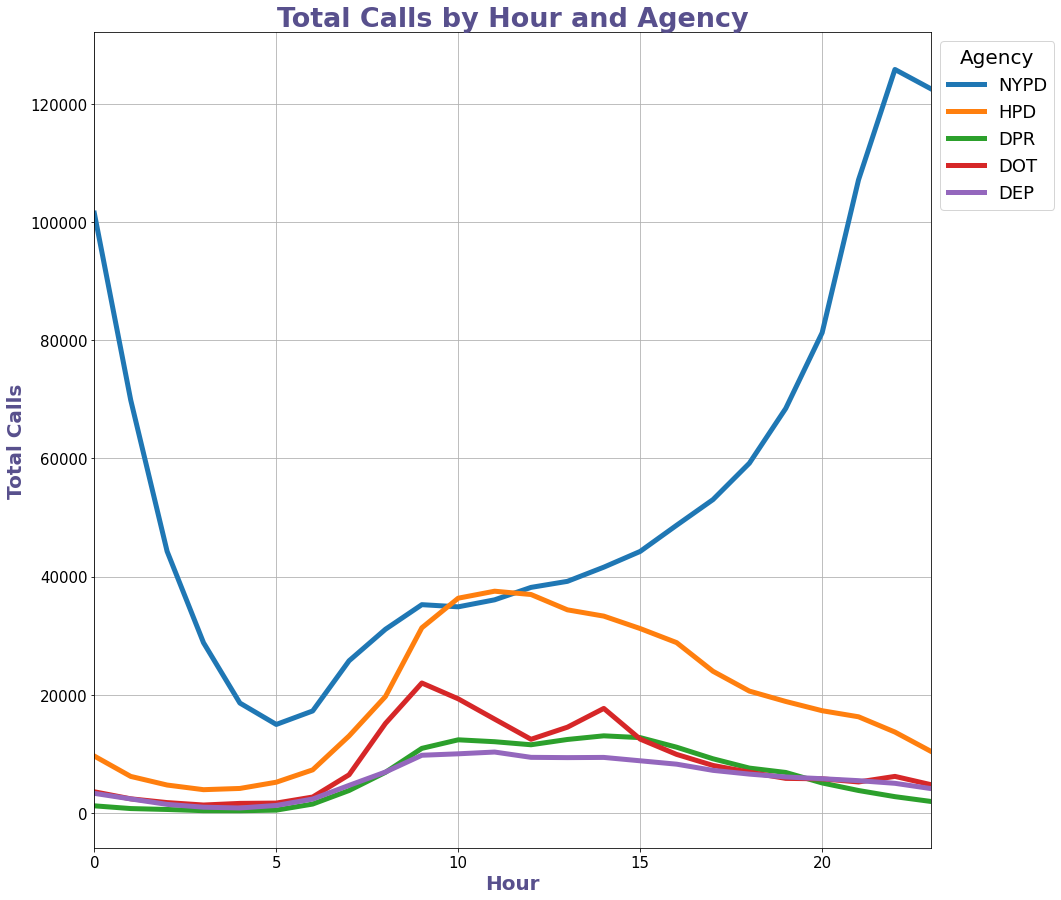

In [ ]:
font_dict = dict(size=20, color="#58508d", fontweight='bold')
title_font_dict = dict(size=27, color="#58508d", fontweight='bold')

plt.figure(figsize=(15, 15))
plt.plot(NYPD.index, NYPD.NYPD, label="NYPD", linewidth=5)
plt.plot(HPD.index, HPD.HPD, label="HPD", linewidth=5)
plt.plot(DPR.index, DPR.DPR, label="DPR", linewidth=5)
plt.plot(DOT.index, DOT.DOT, label="DOT", linewidth=5)
plt.plot(DEP.index, DEP.DEP, label="DEP", linewidth=5)
plt.ylabel('Total Calls', fontdict=font_dict)
plt.xlabel('Hour', fontdict=font_dict)
plt.title('Calls Timestamp During Covid', fontdict=title_font_dict)
plt.legend(title="Agency", title_fontsize=20, fontsize=18, 
           bbox_to_anchor=[1,1]) #position legend outside of plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(right=23) 
plt.xlim(left=0) 
plt.grid()

In [ ]:
NYPD = hour_call_freq_df(False,'NYPD')
HPD = hour_call_freq_df(False,'HPD')
DPR = hour_call_freq_df(False,'DPR')
DOT = hour_call_freq_df(False,'DOT')
DEP = hour_call_freq_df(False,'DEP')
DSNY = hour_call_freq_df(False,'DSNY')

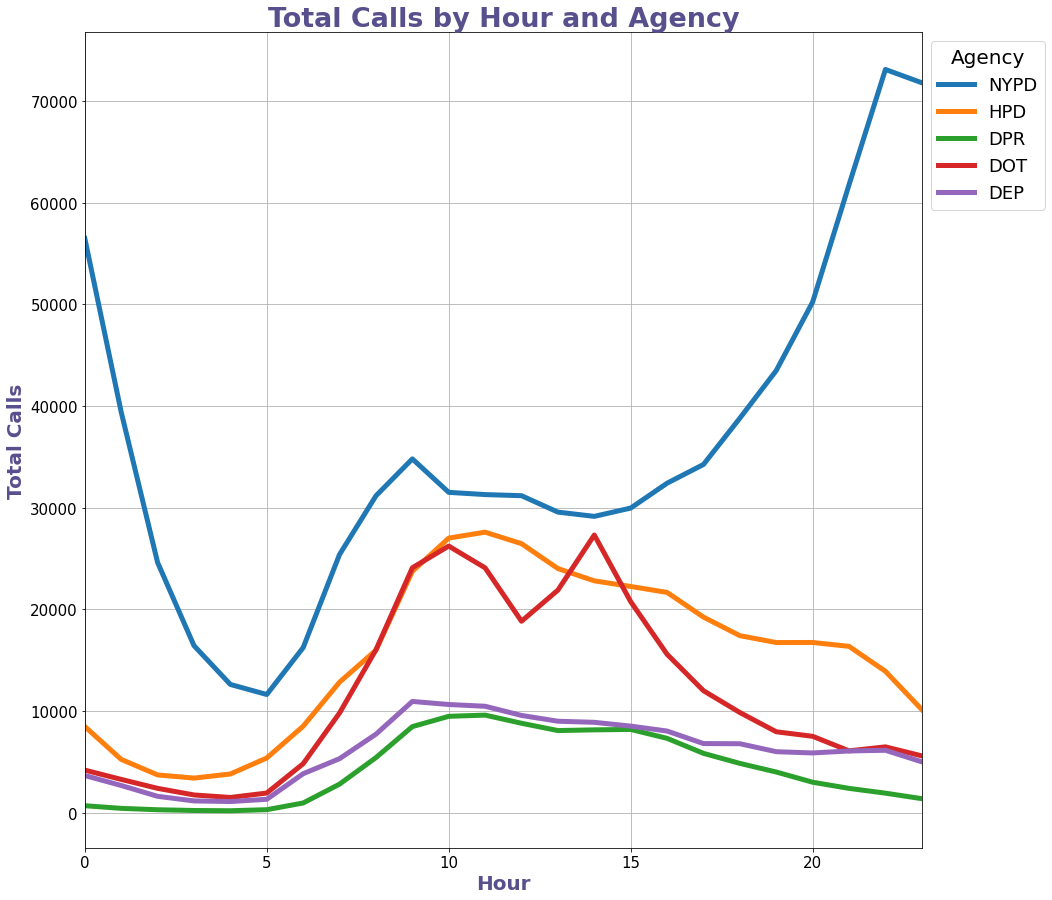

In [ ]:
font_dict = dict(size=20, color="#58508d", fontweight='bold')
title_font_dict = dict(size=27, color="#58508d", fontweight='bold')

plt.figure(figsize=(15, 15))
plt.plot(NYPD.index, NYPD.NYPD, label="NYPD", linewidth=5)
plt.plot(HPD.index, HPD.HPD, label="HPD", linewidth=5)
plt.plot(DPR.index, DPR.DPR, label="DPR", linewidth=5)
plt.plot(DOT.index, DOT.DOT, label="DOT", linewidth=5)
plt.plot(DEP.index, DEP.DEP, label="DEP", linewidth=5)
plt.ylabel('Total Calls', fontdict=font_dict)
plt.xlabel('Hour', fontdict=font_dict)
plt.title('Total Calls by Hour and Agency', fontdict=title_font_dict)
plt.legend(title="Agency", title_fontsize=20, fontsize=18, 
           bbox_to_anchor=[1,1]) #position legend outside of plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(right=23) 
plt.xlim(left=0) 
plt.grid()

In [ ]:
def call_freq_df(cov,complaint_type):
  
  """Takes in a complaint type as a string. Returns a dataframe with dates 
     and the total number of calls related to the given complaint that were made 
     on each date."""
  if cov:
    subset = covid[covid['Complaint Type']==complaint_type]
  else:
      subset = nocovid[nocovid['Complaint Type']==complaint_type]
  
  call_freqs_by_date = {}
    
  for date in subset['Created Date'].dt.date:
      
      if date not in call_freqs_by_date: 
            call_freqs_by_date[date] = 1
        
      else:
            call_freqs_by_date[date] += 1
    
  freq_df = pd.DataFrame.from_dict(call_freqs_by_date, orient='index', 
                                   columns=['{}'.format(complaint_type)])
    
  return freq_df

In [ ]:
mgc = call_freq_df(True,'Mass Gathering Complaint')

In [ ]:
#create and show area plot for COVID-related complaints
covid_fig = go.Figure()


covid_fig.add_trace(go.Scatter(
    x=mgc.index, y=mgc['Mass Gathering Complaint'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#000000'), name="Mass Gathering Complaint",
    stackgroup='two'
))
    
covid_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.001
))


covid_fig.update_layout(title="COVID-19", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

covid_fig.show()

In [ ]:
noise_r = call_freq_df(True,'Noise - Residential')
noise_c = call_freq_df(True,'Noise - Commercial')
noise_v = call_freq_df(True,'Noise - Vehicle')
noise_s = call_freq_df(True,'Noise - Street/Sidewalk')
noise = call_freq_df(True,'Noise - Unspecified')

In [ ]:
noise_fig = go.Figure()

noise_fig.add_trace(go.Scatter(
    x=noise_r.index, y=noise_r['Noise - Residential'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#003f5c'), name="Noise - Residential",
    stackgroup='one'
))
    
noise_fig.add_trace(go.Scatter(
    x=noise_s.index, y=noise_s['Noise - Street/Sidewalk'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#58508d'), name='Noise - Street/Sidewalk',
    stackgroup='two' 
))

noise_fig.add_trace(go.Scatter(
    x=noise_v.index, y=noise_v['Noise - Vehicle'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#bc5090'), name='Noise - Vehicle',
    stackgroup='three' 
))

noise_fig.add_trace(go.Scatter(
    x=noise_c.index, y=noise_c['Noise - Commercial'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#ffa600'), name='Noise - Commercial',
    stackgroup='four' 
))
'''
noise_fig.add_trace(go.Scatter(
    x=noise.index, y=noise['Noise - Unspecified'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#003f5c'), name="Noise - Unspecified",
    stackgroup='one'
))
'''

noise_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

noise_fig.update_layout(title="Noise", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

noise_fig.show()

In [ ]:
noise_r = call_freq_df(False,'Noise - Residential')
noise_c = call_freq_df(False,'Noise - Commercial')
noise_v = call_freq_df(False,'Noise - Vehicle')
noise_s = call_freq_df(False,'Noise - Street/Sidewalk')
noise = call_freq_df(False,'Noise - Unspecified')

In [ ]:
noise_fig = go.Figure()

noise_fig.add_trace(go.Scatter(
    x=noise_r.index, y=noise_r['Noise - Residential'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#003f5c'), name="Noise - Residential",
    stackgroup='one'
))
    
noise_fig.add_trace(go.Scatter(
    x=noise_s.index, y=noise_s['Noise - Street/Sidewalk'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#58508d'), name='Noise - Street/Sidewalk',
    stackgroup='two' 
))

noise_fig.add_trace(go.Scatter(
    x=noise_v.index, y=noise_v['Noise - Vehicle'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#bc5090'), name='Noise - Vehicle',
    stackgroup='three' 
))

noise_fig.add_trace(go.Scatter(
    x=noise_c.index, y=noise_c['Noise - Commercial'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#ffa600'), name='Noise - Commercial',
    stackgroup='four' 
))
'''
noise_fig.add_trace(go.Scatter(
    x=noise.index, y=noise['Noise - Unspecified'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#003f5c'), name="Noise - Unspecified",
    stackgroup='one'
))
'''
noise_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

noise_fig.update_layout(title="Noise", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

noise_fig.show()

In [ ]:
street = call_freq_df(True,'Street Condition')
sidewalk = call_freq_df(True,'Sidewalk Condition')

In [ ]:
condition_fig = go.Figure()
condition_fig.add_trace(go.Scatter(
    x=street.index, y=street["Street Condition"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#22DDD3'), name="Street Condition",
    stackgroup='one'
    ))
    
condition_fig.add_trace(go.Scatter(
    x=sidewalk.index, y=sidewalk["Sidewalk Condition"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#6722DD'), name="Sidewalk Condition",
    stackgroup='one' 


))

condition_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

condition_fig.update_layout(title="Sidewalk and Street Condition", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

condition_fig.show()

In [ ]:
street = call_freq_df(False,'Street Condition')
sidewalk = call_freq_df(False,'Sidewalk Condition')

In [ ]:
condition_fig = go.Figure()
condition_fig.add_trace(go.Scatter(
    x=street.index, y=street["Street Condition"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#22DDD3'), name="Street Condition",
    stackgroup='one'
    ))
    
condition_fig.add_trace(go.Scatter(
    x=sidewalk.index, y=sidewalk["Sidewalk Condition"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#6722DD'), name="Sidewalk Condition",
    stackgroup='one' 


))

condition_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

condition_fig.update_layout(title="Sidewalk and Street Condition", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

condition_fig.show()

In [ ]:
covidbor=covid[covid.Borough!='Unspecified']
nocovidbor=nocovid[nocovid.Borough!='Unspecified']

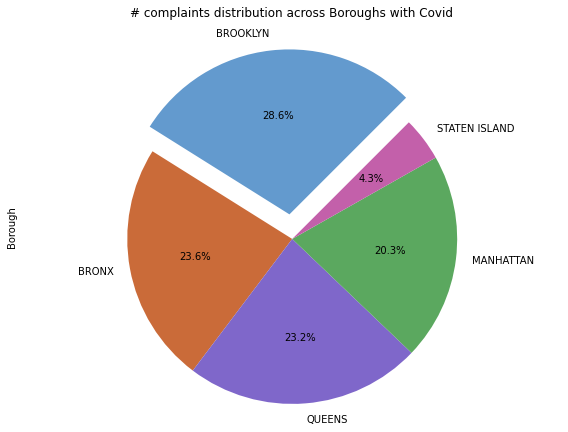

In [ ]:
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
covidbor['Borough'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        explode = (0.15, 0, 0, 0, 0), startangle=45, shadow=False, colors = colors,
                        figsize = (8,6))
#plt.legend(title='BOROUGH', loc='upper right', bbox_to_anchor=(1.5,1))
plt.axis('equal')
plt.title('# complaints distribution across Boroughs with Covid\n')
plt.tight_layout()
plt.show()

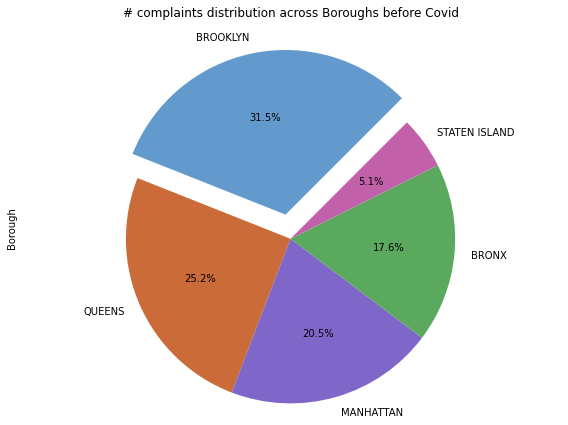

In [ ]:
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
nocovidbor['Borough'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        explode = (0.15, 0, 0, 0, 0), startangle=45, shadow=False, colors = colors,
                        figsize = (8,6))
#plt.legend(title='BOROUGH', loc='upper right', bbox_to_anchor=(1.5,1))
plt.axis('equal')
plt.title('# complaints distribution across Boroughs before Covid\n')
plt.tight_layout()
plt.show()

(-74.27977648606151,
 -73.67383677199024,
 40.478736231062825,
 40.933541774566834)

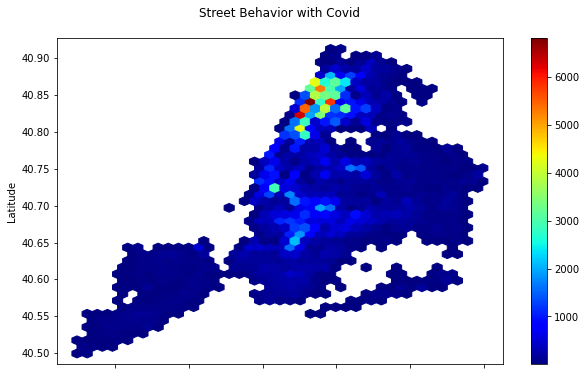

In [ ]:
df_perfect_Air = covid.loc[covid['Complaint Type'].isin(['Urinating in Public','Noise - Street/Sidewalk','Sidewalk Condition','Root/Sewer/Sidewalk Condition','Illegal Tree Damage','Noise - Park'])]
df_perfect_Air.plot(kind='hexbin', x='Longitude', y='Latitude', gridsize=40,
    colormap = 'jet',mincnt=1,title = 'Street Behavior with Covid\n', figsize=(10,6)).axis('equal')

(-74.28068397823328,
 -73.67371109762935,
 40.478738288191025,
 40.933498574874555)

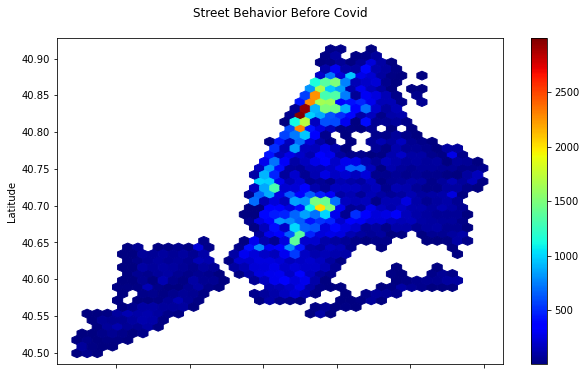

In [ ]:
df_perfect_Air = nocovid.loc[nocovid['Complaint Type'].isin(['Urinating in Public','Noise - Street/Sidewalk','Sidewalk Condition','Root/Sewer/Sidewalk Condition','Illegal Tree Damage','Noise - Park'])]
df_perfect_Air.plot(kind='hexbin', x='Longitude', y='Latitude', gridsize=40,
    colormap = 'jet',mincnt=1,title = 'Street Behavior Before Covid\n', figsize=(10,6)).axis('equal')

In [ ]:
air=covid.loc[covid['Complaint Type'].isin(['Urinating in Public','Noise - Street/Sidewalk','Sidewalk Condition','Root/Sewer/Sidewalk Condition','Illegal Tree Damage','Noise - Park'])]

In [ ]:
aircov=air.groupby(['Borough'])['Complaint Type'].count().nlargest(30)

In [ ]:
aircov

Borough
MANHATTAN        81004
BRONX            68822
BROOKLYN         60396
QUEENS           36891
STATEN ISLAND     6984
Unspecified        434
Name: Complaint Type, dtype: int64

In [ ]:
noair=nocovid.loc[nocovid['Complaint Type'].isin(['Urinating in Public','Noise - Street/Sidewalk','Sidewalk Condition','Root/Sewer/Sidewalk Condition','Illegal Tree Damage','Noise - Park'])]
noaircov=noair.groupby(['Borough'])['Complaint Type'].count().nlargest(30)
noaircov

Borough
BROOKLYN         50798
MANHATTAN        43676
BRONX            32190
QUEENS           27704
STATEN ISLAND     6738
Unspecified        219
Name: Complaint Type, dtype: int64

In [ ]:
(noaircov-aircov)*100/noaircov

Borough
BRONX           -113.799317
BROOKLYN         -18.894445
MANHATTAN        -85.465702
QUEENS           -33.161276
STATEN ISLAND     -3.650935
Unspecified      -98.173516
Name: Complaint Type, dtype: float64

In [ ]:
bcov=covid.groupby(['Borough'])['Complaint Type'].count().nlargest(30)
bnocov=nocovid.groupby(['Borough'])['Complaint Type'].count().nlargest(30)

In [ ]:
bcov

Borough
BROOKLYN         750876
BRONX            620551
QUEENS           608525
MANHATTAN        534386
STATEN ISLAND    112715
Unspecified       22574
Name: Complaint Type, dtype: int64

##### apriori

In [ ]:
Start =pd.to_datetime("2019-03-01",format='%Y-%m-%d')
End = pd.to_datetime("2019-04-01",format='%Y-%m-%d')
mask = ((nocovid['Created Date'] > Start) & (nocovid['Created Date'] <= End))
nocovid1=nocovid.loc[mask]
nocovid1

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Date
56,41849202,2019-03-01 00:00:07,03/05/2019 08:30:56 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10461,1560 PELHAM PARKWAY SOUTH,PELHAM PARKWAY SOUTH,NaN,NaN,NaN,NaN,ADDRESS,BRONX,NaN,NaN,Closed,NaN,The complaint you filed is a duplicate of a co...,03/05/2019 08:30:56 AM,11 BRONX,2.042220e+09,BRONX,1028178.0,251446.0,PHONE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.856727,-73.841202,"(40.85672674385295, -73.8412023734185)",2019-03-01
57,41836528,2019-03-01 00:00:20,03/02/2019 08:57:17 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10456,315 EAST 166 STREET,EAST 166 STREET,COLLEGE AVENUE,FINDLAY AVENUE,NaN,NaN,ADDRESS,BRONX,NaN,Precinct,Closed,03/01/2019 08:00:20 AM,The Police Department reviewed your complaint ...,03/02/2019 08:57:17 AM,04 BRONX,2.024340e+09,BRONX,1007998.0,241700.0,PHONE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.830054,-73.914187,"(40.83005418529265, -73.91418655907765)",2019-03-01
58,41844157,2019-03-01 00:01:04,03/01/2019 12:59:47 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,10002,123 MADISON STREET,MADISON STREET,MARKET STREET,MECHANICS ALLEY,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,03/01/2019 08:01:04 AM,The Police Department responded to the complai...,03/01/2019 12:59:47 AM,03 MANHATTAN,1.002750e+09,MANHATTAN,985898.0,198802.0,ONLINE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.712342,-73.994055,"(40.71234216003643, -73.99405546657133)",2019-03-01
59,41852132,2019-03-01 00:01:06,03/26/2019 01:42:19 PM,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER SUPPLY,RESIDENTIAL BUILDING,10013,68 MOTT STREET,MOTT STREET,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaN,The Department of Housing Preservation and Dev...,03/26/2019 01:42:19 PM,03 MANHATTAN,1.002010e+09,MANHATTAN,984768.0,200206.0,ONLINE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.716196,-73.998131,"(40.71619594310532, -73.99813140390948)",2019-03-01
60,41837399,2019-03-01 00:02:15,03/01/2019 12:52:42 AM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11207,29 COVERT STREET,COVERT STREET,BROADWAY,BUSHWICK AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,Precinct,Closed,03/01/2019 08:02:15 AM,The Police Department responded to the complai...,03/01/2019 12:52:42 AM,04 BROOKLYN,3.034140e+09,BROOKLYN,1008380.0,189080.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.685625,-73.912995,"(40.68562480033797, -73.91299505904317)",2019-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222715,42113166,2019-04-01 00:00:00,04/01/2019 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,1-2 Family Dwelling,11235,185 MACKENZIE STREET,MACKENZIE STREET,SHORE BOULEVARD,JUGHANDLE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,05/01/2019 10:42:28 PM,The Department of Health and Mental Hygiene wi...,04/01/2019 12:00:00 AM,15 BROOKLYN,3.087560e+09,BROOKLYN,1000940.0,150223.0,ONLINE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.578988,-73.939917,"(40.57898775971379, -73.93991736972812)",2019-04-01
222716,42113224,2019-04-01 0

In [ ]:
Start =pd.to_datetime("2020-03-01",format='%Y-%m-%d')
End = pd.to_datetime("2020-04-01",format='%Y-%m-%d')
mask = ((covid['Date'] > Start) & (covid['Date'] <= End))
covid1=covid.loc[mask]
covid1

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Date
4662,45733395,2020-03-02 00:00:00,03/11/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Other (Explain Below),10033.0,4227 BROADWAY,BROADWAY,WEST 179 STREET,WEST 180 STREET,WEST 179 STREET,WEST 180 STREET,ADDRESS,NEW YORK,BROADWAY,NaN,Closed,NaN,The Health Departmentâs Office of Environmen...,03/11/2020 05:14:51 PM,12 MANHATTAN,1.021760e+09,MANHATTAN,1001729.0,248661.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.849175,-73.936821,"(40.84917473118652, -73.93682145089919)",2020-03-02
4663,45737290,2020-03-02 00:00:00,03/11/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Other (Explain Below),10461.0,2724 EAST TREMONT AVENUE,EAST TREMONT AVENUE,ST RAYMOND AVENUE,FRISBY AVENUE,ST RAYMOND AVENUE,FRISBY AVENUE,ADDRESS,BRONX,EAST TREMONT AVENUE,NaN,Closed,NaN,The Department of Health and Mental Hygiene re...,03/11/2020 05:15:24 PM,10 BRONX,2.039880e+09,BRONX,1027111.0,246226.0,ONLINE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.842405,-73.845093,"(40.84240465421344, -73.84509288922673)",2020-03-02
4664,45738263,2020-03-02 00:00:00,03/10/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Food Cart Vendor,10036.0,1221 AVENUE OF THE AMERICAS,AVENUE OF THE AMERICAS,AVENUE OF THE AMERICAS,7 AVENUE,AVENUE OF THE AMERICAS,7 AVENUE,ADDRESS,NEW YORK,AVENUE OF THE AMERICAS,NaN,Closed,NaN,The Health Departmentâs Office of Environmen...,03/10/2020 01:24:56 PM,05 MANHATTAN,1.010010e+09,MANHATTAN,989199.0,215838.0,ONLINE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.759101,-73.982136,"(40.759100542939876, -73.98213583232855)",2020-03-02
4665,45738274,2020-03-02 00:00:00,03/10/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10010.0,EAST 26 STREET,EAST 26 STREET,EAST 26 STREET,LEXINGTON AVENUE,EAST 26 STREET,LEXINGTON AVENUE,ADDRESS,NaN,NaN,NaN,Closed,NaN,The Health Departmentâs Office of Environmen...,03/10/2020 01:29:51 PM,05 MANHATTAN,NaN,MANHATTAN,988861.0,209394.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.741414,-73.983360,"(40.741413572668094, -73.98336031317677)",2020-03-02
4666,45740222,2020-03-02 00:00:00,03/11/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11354.0,34-40 UNION STREET,UNION STREET,34 ROAD,35 AVENUE,34 ROAD,35 AVENUE,ADDRESS,Flushing,UNION STREET,NaN,Closed,NaN,The Health Departmentâs Office of Environmen...,03/11/2020 05:11:54 PM,07 QUEENS,4.049560e+09,QUEENS,1031965.0,218364.0,ONLINE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.765906,-73.827748,"(40.76590638205973, -73.82774774545959)",2020-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162261,45931796,2020-04-01 23:58:21,04/02/2020 08:22:59 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,11238.0,365 LINCOLN PLACE,LINCOLN PLACE,NaN,NaN,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Department of Housing Preservation and Dev...,04/02/2020 08:22:59 AM,08 BROOKLYN,3.011760e+09,BROOKLYN,994226.0,184487.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.673045,-73.964037,"(40.67

In [ ]:
covbrooklyn = covid1[covid1["Borough"]== 'BROOKLYN'][['Complaint Type','Incident Zip']]
covqueens = covid1[covid1["Borough"]== 'QUEENS'][['Complaint Type','Incident Zip']]
covbronx = covid1[covid1["Borough"]== 'BRONX'][['Complaint Type','Incident Zip']]
covmanhattan = covid1[covid1["Borough"]== 'MANHATTAN'][['Complaint Type','Incident Zip']]
covstaten = covid1[covid1["Borough"]== 'STATEN ISLAND'][['Complaint Type','Incident Zip']]


nocovbrooklyn = nocovid1[nocovid1["Borough"]== 'BROOKLYN'][['Complaint Type','Incident Zip']]
nocovqueens = nocovid1[nocovid1["Borough"]== 'QUEENS'][['Complaint Type','Incident Zip']]
nocovbronx = nocovid1[nocovid1["Borough"]== 'BRONX'][['Complaint Type','Incident Zip']]
nocovmanhattan = nocovid1[nocovid1["Borough"]== 'MANHATTAN'][['Complaint Type','Incident Zip']]
nocovstaten = nocovid1[nocovid1["Borough"]== 'STATEN ISLAND'][['Complaint Type','Incident Zip']]

In [ ]:
basket_covbrooklyn =(covbrooklyn 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_nocovbrooklyn =(nocovbrooklyn 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_covqueens =(covqueens 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_nocovqueens =(nocovqueens 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_covbronx =(covbronx 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_nocovbronx =(nocovbronx
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_covmanhattan =(covmanhattan 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_nocovmanhattan =(nocovmanhattan 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_covstaten =(covstaten 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

basket_nocovstaten =(nocovstaten 
          .groupby(['Incident Zip','Complaint Type'])['Complaint Type']
          .count().unstack().reset_index().fillna(0) 
          .set_index('Incident Zip')) 

In [ ]:
def hot_encode(x): 
    if(x<= 9): 
        return 0
    if(x>= 10): 
        return 1

In [ ]:
basket_encoded = basket_covbrooklyn.applymap(hot_encode) 
basket_covbrooklyn = basket_encoded 

basket_encoded = basket_nocovbrooklyn.applymap(hot_encode) 
basket_nocovbrooklyn = basket_encoded 

basket_encoded = basket_covqueens.applymap(hot_encode) 
basket_covqueens = basket_encoded 

basket_encoded = basket_nocovqueens.applymap(hot_encode) 
basket_nocovqueens = basket_encoded 

basket_encoded = basket_covbronx.applymap(hot_encode) 
basket_covbronx = basket_encoded 


basket_encoded = basket_nocovbronx.applymap(hot_encode) 
basket_nocovbronx = basket_encoded 

basket_encoded = basket_covmanhattan.applymap(hot_encode) 
basket_covmanhattan = basket_encoded 

basket_encoded = basket_nocovmanhattan.applymap(hot_encode) 
basket_nocovmanhattan = basket_encoded 

basket_encoded = basket_covstaten.applymap(hot_encode) 
basket_covstaten = basket_encoded 

basket_encoded = basket_nocovstaten.applymap(hot_encode) 
basket_nocovstaten = basket_encoded 

In [ ]:
nocovid

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Date
0,41842452,2019-03-01,03/01/2019 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Construction Site,10023,10W WEST 66 STREET,WEST 66 STREET,CENTRAL PARK WEST,COLUMBUS AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,03/31/2019 01:31:27 AM,The Department of Health and Mental Hygiene wi...,03/01/2019 12:00:00 AM,07 MANHATTAN,1.011180e+09,MANHATTAN,989977.0,220778.0,ONLINE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.772659,-73.979323,"(40.77265909494036, -73.97932331414397)",2019-03-01
1,41845294,2019-03-01,03/13/2019 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Parking Lot/Garage,11215,258 8 STREET,8 STREET,NaN,NaN,NaN,NaN,LATLONG,BROOKLYN,NaN,NaN,Closed,03/31/2019 09:37:54 PM,The Department of Health and Mental Hygiene wi...,03/13/2019 12:00:00 AM,Unspecified BROOKLYN,NaN,BROOKLYN,987943.0,183450.0,MOBILE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.670204,-73.986687,"(40.67020384485379, -73.9866873225645)",2019-03-01
2,41845295,2019-03-01,03/05/2019 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),10037,WEST 135 STREET,WEST 135 STREET,5 AVENUE,LENOX AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Closed,03/31/2019 08:13:14 PM,The Department of Health and Mental Hygiene wi...,03/05/2019 12:00:00 AM,Unspecified MANHATTAN,NaN,MANHATTAN,1001279.0,235518.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.813102,-73.938481,"(40.81310185734788, -73.93848135637793)",2019-03-01
3,41845297,2019-03-01,03/07/2019 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10128,333 EAST 92 STREET,EAST 92 STREET,2 AVENUE,1 AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,03/31/2019 03:23:28 PM,The Department of Health and Mental Hygiene wi...,03/07/2019 12:00:00 AM,08 MANHATTAN,1.015550e+09,MANHATTAN,998635.0,223936.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.781317,-73.948058,"(40.78131712272279, -73.94805782860429)",2019-03-01
4,41845941,2019-03-01,03/01/2019 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Signs of Rodents,1-2 Family Dwelling,10473,1212 HARDING PARK,HARDING PARK,NaN,NaN,NaN,NaN,LATLONG,BRONX,NaN,NaN,Closed,03/31/2019 12:11:11 PM,The Department of Health and Mental Hygiene wi...,03/01/2019 12:13:45 PM,Unspecified BRONX,NaN,BRONX,1023544.0,234269.0,MOBILE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.809603,-73.858055,"(40.80960272939806, -73.85805465057818)",2019-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263566,45723979,2020-02-29,03/06/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Other (Explain Below),11375,108-27 QUEENS BOULEVARD,QUEENS BOULEVARD,71 AVENUE,71 ROAD,71 AVENUE,71 ROAD,ADDRESS,Forest Hills,QUEENS BOULEVARD,NaN,Closed,NaN,The Department of Health and Mental Hygiene re...,03/06/2020 11:04:24 AM,06 QUEENS,4.022240e+09,QUEENS,1027601.0,202103.0,PHONE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721297,-73.843607,"(40.72129654838142, -73.84360665693626)",2020-02-29
2263567,45723980,2020-02-29,03/02/2020 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11235,

In [ ]:
# Building the model 
frq_items = apriori(basket_nocovstaten, min_support = 0.85, use_colnames = True) 
# Collecting the inferred rules in a dataframe 
rules1 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules1 = rules1.sort_values(['confidence', 'lift'], ascending =[False, False])
print("BEFORE COVID") 
print(rules1.head()) 
# Building the model 
frq_items = apriori(basket_covstaten, min_support = 0.90, use_colnames = True) 
# Collecting the inferred rules in a dataframe 
rules2 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules2 = rules2.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("DURING COVID")
print(rules2.head())
 


BEFORE COVID
                             antecedents  ... conviction
1                      (Illegal Parking)  ...        inf
2  (Request Large Bulky Item Collection)  ...        inf
3        (Electronics Waste Appointment)  ...        inf
5                     (Street Condition)  ...        inf
7                      (Illegal Parking)  ...        inf

[5 rows x 9 columns]
DURING COVID
                           antecedents  ... conviction
0  (Missed Collection (All Materials))  ...        inf
1                    (Illegal Parking)  ...        inf
2                (Noise - Residential)  ...        inf
3                    (Illegal Parking)  ...        inf
4                   (Street Condition)  ...        inf

[5 rows x 9 columns]


In [ ]:
ok4=rules2[rules2['confidence']==1]['antecedents'].reset_index()
ok4['antecedents']

0                   (Missed Collection (All Materials))
1                                     (Illegal Parking)
2                                 (Noise - Residential)
3                                     (Illegal Parking)
4                                    (Street Condition)
5                              (Street Light Condition)
6                   (Missed Collection (All Materials))
7                                 (Noise - Residential)
8                                    (Street Condition)
9                              (Street Light Condition)
10                                   (Street Condition)
11                             (Street Light Condition)
12    (Missed Collection (All Materials), Noise - Re...
13    (Missed Collection (All Materials), Illegal Pa...
14               (Noise - Residential, Illegal Parking)
15                  (Missed Collection (All Materials))
16                                (Noise - Residential)
17                                    (Illegal P

DURING COVID
                                             antecedents  ... conviction
18040  (Street Light Condition, Sewer, Consumer Compl...  ...        inf
18041               (Blocked Driveway, Dirty Conditions)  ...        inf
18070          (Sewer, Water System, Consumer Complaint)  ...        inf
18071               (Blocked Driveway, Dirty Conditions)  ...        inf
29533  (Abandoned Vehicle, Street Light Condition, Se...  ...        inf

[5 rows x 9 columns]


In [ ]:
# Building the model 
frq_items = apriori(basket_nocovmanhattan, min_support = 0.3, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules3 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules3 = rules3.sort_values(['confidence', 'lift'], ascending =[False, False])
print("BEFORE COVID") 
print(rules3.head()) 

# Building the model 
frq_items = apriori(basket_covmanhattan, min_support = 0.42, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules4 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules4 = rules4.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("DURING COVID")
print(rules4.head()) 

BEFORE COVID
                                          antecedents  ... conviction
82            (Noise - Residential, Street Condition)  ...  25.412587
40                 (HEAT/HOT WATER, Street Condition)  ...  12.706294
77  (Request Large Bulky Item Collection, Illegal ...  ...  12.706294
35                  (Illegal Parking, HEAT/HOT WATER)  ...   9.575758
59  (Request Large Bulky Item Collection, HEAT/HOT...  ...   8.839161

[5 rows x 9 columns]
DURING COVID
                                 antecedents  ... conviction
59                        (Street Condition)  ...        inf
104      (Illegal Parking, Street Condition)  ...        inf
120  (Noise - Residential, Street Condition)  ...        inf
26      (Consumer Complaint, HEAT/HOT WATER)  ...        inf
9                         (Street Condition)  ...        inf

[5 rows x 9 columns]


In [ ]:
ok4=rules4[rules4['confidence']==1]['antecedents'].reset_index()
ok4['antecedents']

0                                    (Street Condition)
1                   (Illegal Parking, Street Condition)
2               (Noise - Residential, Street Condition)
3                  (Consumer Complaint, HEAT/HOT WATER)
4                                    (Street Condition)
5                                    (Street Condition)
6                 (Noise - Residential, HEAT/HOT WATER)
7                   (Illegal Parking, Street Condition)
8                             (Noise, Street Condition)
9                (Consumer Complaint, Street Condition)
10              (Noise - Residential, Street Condition)
11                  (Illegal Parking, Street Condition)
12              (Noise - Residential, Street Condition)
13           (Noise, Illegal Parking, Street Condition)
14    (Illegal Parking, Consumer Complaint, Street C...
15       (Noise, Noise - Residential, Street Condition)
16    (Noise - Residential, Consumer Complaint, Stre...
Name: antecedents, dtype: object

In [ ]:
# Building the model 
frq_items = apriori(basket_nocovbronx, min_support = 0.75, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules5 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules5 = rules5.sort_values(['confidence', 'lift'], ascending =[False, False])
print("BEFORE COVID") 
print(rules5.head()) 

# Building the model 
frq_items = apriori(basket_covbronx, min_support = 0.85, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules6 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules6 = rules6.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("DURING COVID")
print(rules6.head()) 

BEFORE COVID
                            antecedents  ... conviction
9                      (HEAT/HOT WATER)  ...        inf
15                   (Street Condition)  ...        inf
23   (Blocked Driveway, HEAT/HOT WATER)  ...        inf
35    (HEAT/HOT WATER, Illegal Parking)  ...        inf
41  (Illegal Parking, Street Condition)  ...        inf

[5 rows x 9 columns]
DURING COVID
                                          antecedents  ... conviction
29            (Noise - Residential, Street Condition)  ...        inf
32                               (Consumer Complaint)  ...        inf
47  (Illegal Parking, Noise - Residential, Street ...  ...        inf
50            (Noise - Residential, Street Condition)  ...        inf
55              (Consumer Complaint, Illegal Parking)  ...        inf

[5 rows x 9 columns]


In [ ]:
ok4=rules6[rules6['confidence']==1]['antecedents'].reset_index()
ok4['antecedents']

0               (Noise - Residential, Street Condition)
1                                  (Consumer Complaint)
2     (Illegal Parking, Noise - Residential, Street ...
3               (Noise - Residential, Street Condition)
4                 (Consumer Complaint, Illegal Parking)
5                                  (Consumer Complaint)
6                                  (Consumer Complaint)
7                                  (Consumer Complaint)
8                                      (HEAT/HOT WATER)
9                 (Consumer Complaint, Illegal Parking)
10                                 (Consumer Complaint)
11                (Consumer Complaint, Illegal Parking)
12                                 (Consumer Complaint)
13            (Noise - Residential, Consumer Complaint)
14               (Consumer Complaint, Street Condition)
15                    (Illegal Parking, HEAT/HOT WATER)
16                                     (HEAT/HOT WATER)
17    (Illegal Parking, Consumer Complaint, Stre

In [ ]:
# Building the model 
frq_items = apriori(basket_nocovqueens, min_support = 0.5, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules7 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules7 = rules7.sort_values(['confidence', 'lift'], ascending =[False, False])
print("BEFORE COVID") 
print(rules7.head()) 

# Building the model 
frq_items = apriori(basket_covqueens, min_support = 0.3, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules8 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules8 = rules8.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("DURING COVID")
print(rules8.head()) 

BEFORE COVID
                                          antecedents  ... conviction
11                                  (Illegal Parking)  ...        inf
28                (Blocked Driveway, Illegal Parking)  ...        inf
58             (Noise - Residential, Illegal Parking)  ...        inf
69                (Illegal Parking, Street Condition)  ...        inf
83  (Blocked Driveway, Noise - Residential, Illega...  ...        inf

[5 rows x 9 columns]
DURING COVID
                                             antecedents  ... conviction
8354   (Blocked Driveway, Missed Collection (All Mate...  ...        inf
9404   (Blocked Driveway, Missed Collection (All Mate...  ...        inf
20696  (Blocked Driveway, Missed Collection (All Mate...  ...        inf
20709  (Blocked Driveway, Missed Collection (All Mate...  ...        inf
21003  (Blocked Driveway, Missed Collection (All Mate...  ...        inf

[5 rows x 9 columns]


In [ ]:
ok4=rules8[rules8['confidence']>0.8]['antecedents'].reset_index()
ok4['antecedents'][6]

frozenset({'Blocked Driveway',
           'Consumer Complaint',
           'Missed Collection (All Materials)',
           'Sewer'})

In [ ]:
# Building the model 
frq_items = apriori(basket_nocovbrooklyn, min_support = 0.8, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules9 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules9 = rules9.sort_values(['confidence', 'lift'], ascending =[False, False])
print("BEFORE COVID") 
print(rules9.head()) 

# Building the model 
frq_items = apriori(basket_covbrooklyn, min_support = 0.88, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules10 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules10 = rules10.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("DURING COVID")
print(rules10.head()) 

BEFORE COVID
                                           antecedents  ... conviction
240                 (HEAT/HOT WATER, Street Condition)  ...        inf
13                                    (HEAT/HOT WATER)  ...        inf
37                  (Blocked Driveway, HEAT/HOT WATER)  ...        inf
85                   (Illegal Parking, HEAT/HOT WATER)  ...        inf
103  (Request Large Bulky Item Collection, HEAT/HOT...  ...        inf

[5 rows x 9 columns]
DURING COVID
                        antecedents  ... conviction
10  (General Construction/Plumbing)  ...        inf
11            (Noise - Residential)  ...        inf
12  (General Construction/Plumbing)  ...        inf
13               (Street Condition)  ...        inf
18            (Noise - Residential)  ...        inf

[5 rows x 9 columns]


In [ ]:
ok4=rules10[rules10['confidence']==1]['antecedents'].reset_index()
ok4['antecedents'][120]


frozenset({'General Construction/Plumbing', 'Street Condition'})

##### analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

plt.style.use('ggplot')

In [ ]:
df=covid

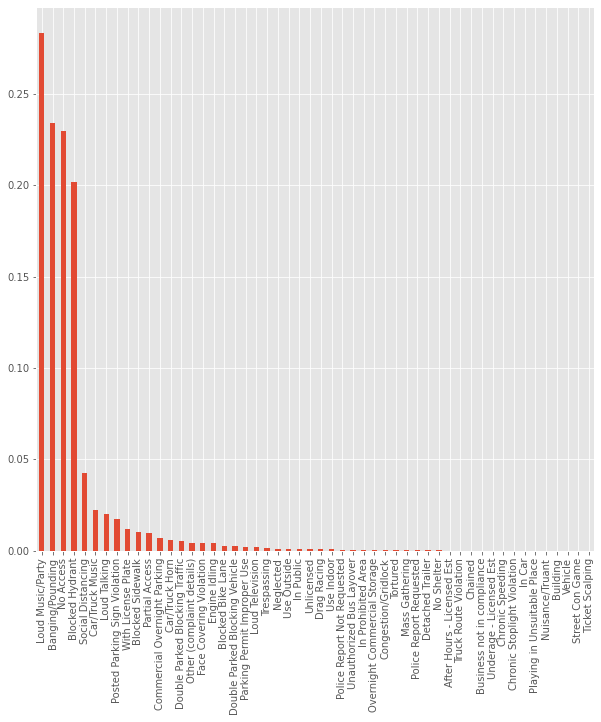

In [ ]:
df["Agency"].value_counts()
(df["Borough"].value_counts()[:10]/df.shape[0]).plot(kind="bar", figsize= (10,10))

(df[df["Agency"]=='NYPD']['Descriptor'].value_counts()/df.shape[0]).plot(kind="bar", figsize= (10,10))


[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of Complaints by Type and Borough')]

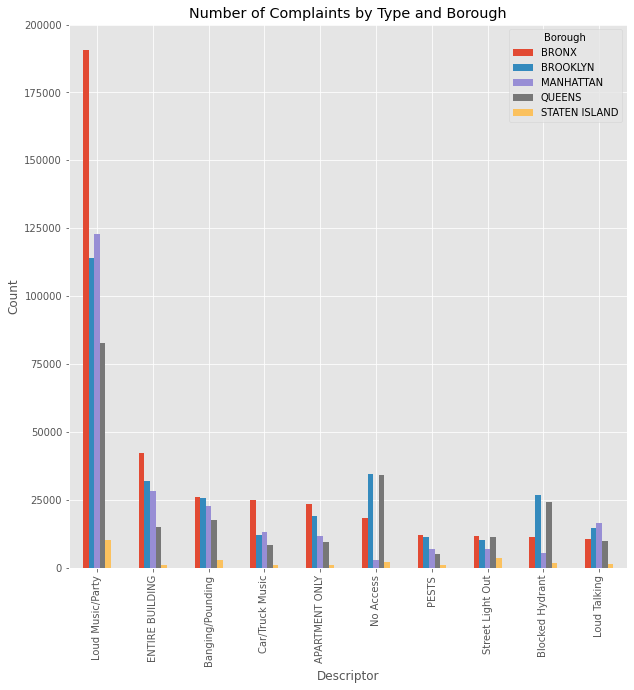

In [ ]:
pivot = df.pivot_table(index="Descriptor", columns = "Borough", values = "Unique Key", aggfunc = "count")
pivot = pivot.sort_values(by=['BRONX'],ascending=False)
pivot.iloc[:10,:5].plot(kind="bar", figsize=(10,10)).set(title="Number of Complaints by Type and Borough", ylabel = "Count")